# Performance on simulated electrons and photons

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from helpers import *
from loaders import *
from initializers import initialisation_for_calorimetry_shower

In [37]:
today = '19_12_03'

In [38]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/pdfs/
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/shower_calo/'
save_folder_pdfs = save_folder + 'pdfs/'

## Loading and initializing

In [4]:
branches = [
    'run',
    'sub',
    'evt',
    
    'generation',
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    'backtracked_start_t',
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'trk_start_x',
    'trk_start_y',
    'trk_start_z',
    
    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_end_x',
    'trk_end_y',
    'trk_end_z',
    
    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
    'x_u',
    'x_v',
    'x_y',
    
    'y_u',
    'y_v',
    'y_y',
    
    'z_u',
    'z_v',
    'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [43]:
# Declaring files, folder and tree

directory = '~/Desktop/MicroBooNE/calorimetry_likelihood/v03/'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.5
split_factor2 = 1

file_lists = {}
arrays_train = {}
arrays_test = {}

file_lists['nue'] = directory + 'bnb_nue_shr/out.root'
file_lists['ccpi0'] = directory + 'bnb_ccpi0_shr/out.root'
file_lists['ncpi0'] = directory + 'bnb_ncpi0_shr/out.root'

In [44]:
#Loading arrays
for name, file_path in file_lists.items():
    root_file = uproot.open(file_path)[folder][tree]
    entry_split = int(len(root_file) * split_factor)
    entry_split2 = int(len(root_file) * split_factor2)
    arrays_train[name] = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
    arrays_test[name] = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [45]:
# Merging nue, nu, and ncpi0
array_train = {}
array_test = {}
for variable in branches:
    array_train[variable] = awkward.concatenate([array[variable] for array in arrays_train.values()])    
    array_test[variable] = awkward.concatenate([array[variable] for array in arrays_test.values()])

In [46]:
# initialising arrays
for array in [array_train, array_test]:
    initialisation_for_calorimetry_shower(array)

In [83]:
def selection_for_train(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['distance_3d_start'] < 2) &\
           (array['distance_3d_start'] > 0) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

def selection_for_test(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['distance_3d_start'] < 2) &\
           (array['distance_3d_start'] > 0)

def electron_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==11)

def photon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==22)

def cosmic_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==0)

In [100]:
#declaring some masks
selection_train = selection_for_train(array_train)
selection_test = selection_for_test(array_test)

electron_train = (abs(array_train['backtracked_pdg']) == 11)
photon_train = (abs(array_train['backtracked_pdg']) == 22)

electron_test = (abs(array_test['backtracked_pdg']) == 11)
photon_test = (abs(array_test['backtracked_pdg']) == 22)

In [56]:
# Easy start point resolution studies

Text(0.0, 1.0, 'Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary')

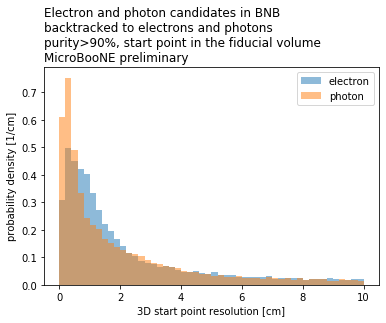

In [57]:
def base_selection_for_res_start_study(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

base_sel = base_selection_for_res_start_study(array_train)
plt.hist(array_train['distance_3d_start'][electron_train & base_sel], bins=50, range=[0, 10], alpha=0.5, density=True, label='electron')
plt.hist(array_train['distance_3d_start'][photon_train & base_sel], bins=50, range=[0, 10], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('3D start point resolution [cm]')
plt.ylabel('probability density [1/cm]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')

Text(0.0, 1.0, 'Photon candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary')

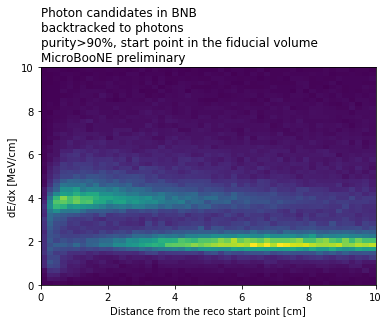

In [58]:
dedx_y = array_train['dedx_y'][photon_train & selection_train]
dist = array_train['dist_from_start_y'][photon_train & selection_train]

plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 10], [0, 10]], bins=[51, 51])
plt.xlabel("Distance from the reco start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Photon candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')

## Lookup Tables

In [60]:
# two parameters
parameters_names = ['dist_from_start', 'pitch']
parameters_bin_edges = [[0., 1, 2, 3, 4, 5, 10],
                  [0.3, 0.6, 1., 1.5, 3]]

dedx_var = 'dedx'
dedx_bins = [0.        , 0.31578947, 0.63157895, 0.94736842, 1.26315789,
       1.57894737, 1.89473684, 2.21052632, 2.52631579, 2.84210526,
       3.15789474, 3.47368421, 3.78947368, 4.10526316, 4.42105263,
       4.73684211, 5.05263158, 5.36842105, 5.68421053, 6. , 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 30, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [101]:
# declaring caloLikelihood objects
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [102]:
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 11)    
    caloLike_train.buildLookUpTableMC(i, 22)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [11, 22])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:140: RuntimeWarning: divide by zero encountered in log
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:140: RuntimeWarning: invalid value encountered in subtract
  np.log(table_1) - np.log(table_2),


In [103]:
caloLike_train.addCalorimetryVariables(caloLike_test.array, pdg_codes=[11, 22], cali=False)
caloLike_train.addCalorimetryVariablesFromLLRTable(caloLike_test.array, cali=False)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:245: RuntimeWarning: divide by zero encountered in log
  return np.log(self.lookup_tables[pdg_code][plane_num][lookup_index])
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:292: RuntimeWarning: invalid value encountered in subtract
  array['log_like_ratio_{}'.format(plane)] = array['like_{}_sum_{}'.format(pdg_codes[0], plane)] - array['like_{}_sum_{}'.format(pdg_codes[1], plane)]
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:294: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:295: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']


In [14]:
# caloLike_train.printCplusplusCode(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_proton_muon_lookup.h', planes=[0, 1, 2])

In [64]:
# DUMP LOOKUP TABLE ON A C++ FILE
# caloLike_train.printCplusplusCode(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/outlookup.h', planes=[0, 1, 2])

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [65]:
# Plot PDF 2parameters
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=11, 
                                  parameters_value=bin_center, 
                                  label='electron')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=22, 
                                  parameters_value=bin_center, 
                                  label='photon')
        plt.xlim(0, 10)
        plt.savefig(save_folder_pdfs+'plane_{}_dist_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]), dpi=250)
        plt.close()

In [64]:
#Plot PDF 1parameters
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=11, 
                                  parameters_value=bin_center, 
                                  label='electron')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=22, 
                                  parameters_value=bin_center, 
                                  label='photon')
        plt.xlim(0, 20)
        plt.savefig(save_folder_pdfs+'plane_{}_pitch_{}.png'.format(plane_num, bin_center[0]), dpi=250)
        plt.close()

## Plots

In [164]:
for array in [array_train, array_test]:
    for plane in ['_u', '_v', '_y']:
        aux_array = array['dedx'+plane][array['dist_from_start'+plane]<4]
        out_array = []
        for i in aux_array:
            out_array.append(np.median(i))
        array['dedx_median_4'+plane] = np.array(out_array)

In [165]:
def add_norm_variable(array, var, scale=100):
    array[var+'_n'] = 2/math.pi*np.arctan(array[var]/scale)

In [166]:
interesting_variables = [
                         'dedx_median_4_u',
                         'dedx_median_4_v',
                         'dedx_median_4_y',
                         'llr_sum_0',
                         'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

variable_labels = {
    'dedx_median_4_u': 'dE/dx U median-4cm',
    'dedx_median_4_v': 'dE/dx V median-4cm',
    'dedx_median_4_y': 'dE/dx Y median-4cm',
    'llr_sum_0': 'LLR U',
    'llr_sum_1': 'LLR V',
    'llr_sum_2': 'LLR Y',
    'llr_01': 'LLR UV',   
    'llr_012': 'LLR UVY',   
}

for variable in interesting_variables:
    if 'llr' in variable:
        scale = 10
    elif 'bragg' in variable:
        scale = 1
    else:
        scale = 10
    add_norm_variable(caloLike_test.array, variable, scale)

In [167]:
bins = 41
hist_range = [-1, 1]
kwargs = {'histtype':'step'}
for var in interesting_variables:
    variable = var + '_n'
    caloLike_test.plotVariableMC(variable, bins, hist_range, function_mask=electron_for_test, quality_mask=True, label='electron', **kwargs);
    caloLike_test.plotVariableMC(variable, bins, hist_range, function_mask=photon_for_test, quality_mask=True, label='photon', **kwargs);
    caloLike_test.plotVariableMCFancy(variable, bins, hist_range, function_mask=cosmic_for_test, quality_mask=True, label='cosmic', **kwargs);
    plt.xlabel(variable_labels[var])
    plt.tight_layout()
    plt.savefig(save_folder + variable + '.png', dpi=250)
    plt.close()

## ROC curves

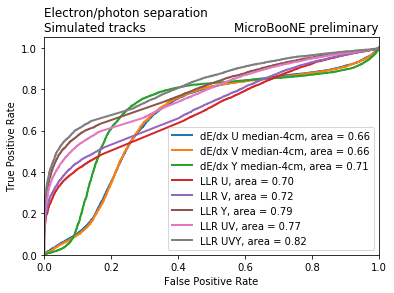

In [168]:
for variable in interesting_variables:
    caloLike_test.rocCurve(variable=variable+'_n', 
         pdg_codes=[11, 22], 
         plot=True,
         variable_label=variable_labels[variable])

plt.title('Electron/photon separation\nSimulated tracks', loc='left')
plt.savefig(save_folder + 'roc_curves.png', dpi=250)

# Old

In [137]:
norm_direction_vector(arrays_train['nue'])
out_mask = np.abs(arrays_train['nue']['norm_dir_y'] -1) > 0.001

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [143]:
arrays_train['nue']['run'][out_mask.any()], arrays_train['nue']['sub'][out_mask.any()], arrays_train['nue']['evt'][out_mask.any()]

(array([7010, 7010, 5151, ..., 7053, 7053, 7001], dtype=uint32),
 array([1217, 1217,  131, ...,    6,    6,  381], dtype=uint32),
 array([60883, 60894,  6590, ...,   331,   343, 19083], dtype=uint32))

In [144]:
arrays_train['nue']['dir_x_y'][out_mask.any()], arrays_train['nue']['dir_y_y'][out_mask.any()], arrays_train['nue']['dir_z_y'][out_mask.any()]

(<JaggedArray [[-999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [-0.22249842 -0.22249842 -0.22249842 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [-999.0 -999.0 -999.0 ... 0.47337908 0.47337908 0.47337908] [0.0 0.0 0.0 ... -0.04409793 -0.064682014 -0.09194935]] at 0x7f3f75c068d0>,
 <JaggedArray [[-999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.1795345 0.1795345 0.1795345 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [-999.0 -999.0 -999.0 ... -0.5046163 -0.5046163 -0.5046163] [0.0 0.0 0.0 ... -0.99649787 -0.9948789 -0.9853971]] at 0x7f3f4eb50c50>,
 <JaggedArray [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.9582599 0.9582599 0.9582599 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.7219935 0.7219935 0.7219935] [0.0 0.0 0.0 ... -0.071044974 -0.077667244 -0.14331038]] at 0x7f3f4eb50750>)